# Create autoencoder to visualize latent space of lung CT scans with and without COVID-19

Code adapted from: https://douglasduhaime.com/posts/visualizing-latent-spaces.html

*Use this as a baseline to compare real images with generated images from the GAN*

Extract COVID CT images for dataset

In [ ]:
import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import zipfile
import pandas as pd
from IPython import display
from PIL import Image
from imutils import paths
import os
import glob
import cv2
from matplotlib import image

from google.colab import drive
drive.mount('/content/gdrive')

Dataset = "CT_COVID"

# !pwd
# Will unzip the files so that you can see them..
with zipfile.ZipFile("/content/gdrive/My Drive/"+Dataset+".zip","r") as z:
    z.extractall("/gdrive/Data")

from subprocess import check_output
print(check_output(["ls", "/gdrive/Data/CT_COVID"]).decode("utf8"))


# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir("/gdrive/Data/CT_COVID")
!pwd

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    # print(img_data.shape)
    data.append(img_data)  


Extract non-COVID CT scans for dataset

In [ ]:
Dataset = "CT_NonCOVID"

with zipfile.ZipFile("/content/gdrive/My Drive/"+Dataset+".zip","r") as z:
    z.extractall("/gdrive/Data")

from subprocess import check_output
print(check_output(["ls", "/gdrive/Data/CT_NonCOVID"]).decode("utf8"))

# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir("/gdrive/Data/CT_NonCOVID")
!pwd

path = "*.*"
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    # print(img_data.shape)

data = np.array(data)

Create autoencoder class

In [ ]:
from keras.models import Model
from keras.layers import Input, Reshape, Dense, Flatten

class Autoencoder:
  def __init__(self, img_shape=(128, 128), latent_dim=2, n_layers=5, n_units=128):
    if not img_shape: raise Exception('Please provide img_shape (height, width) in px')

    # create the encoder
    i = h = Input(img_shape) # the encoder takes as input images
    h = Flatten()(h) # flatten the image into a 1D vector
    for _ in range(n_layers): # add the "hidden" layers
      h = Dense(n_units)(h) # add the units in the ith hidden layer
    o = Dense(latent_dim)(h) # this layer indicates the lower dimensional size
    self.encoder = Model(inputs=[i], outputs=[o])

    # create the decoder
    i = h = Input((latent_dim,)) # the decoder takes as input lower dimensional vectors
    for _ in range(n_layers): # add the "hidden" layers
      h = Dense(n_units)(h) # add the units in the ith hidden layer
    h = Dense(img_shape[0] * img_shape[1])(h) # one unit per pixel in inputs
    o = Reshape(img_shape)(h) # create outputs with the shape of input images
    self.decoder = Model(inputs=[i], outputs=[o])

    # combine the encoder and decoder into a full autoencoder
    i = Input(img_shape) # take as input image vectors
    z = self.encoder(i) # push observations into latent space
    o = self.decoder(z) # project from latent space to feature space
    self.model = Model(inputs=[i], outputs=[o])
    self.model.compile(loss='mse', optimizer='adam')

autoencoder = Autoencoder()

Data preprocessing: convert to grayscale, resize to 128x128, flip left to right for more dense dataset

In [ ]:
from skimage.color import rgb2gray
WIDTH=128
HEIGHT=128
standardized_data = []
for img in data:
  #print(img.shape)
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], WIDTH,HEIGHT).astype('float32')

print(train_images.shape)

Train images with autoencoder for 100 epochs

In [ ]:
autoencoder.model.fit(train_images, train_images, batch_size=64, epochs=100)

Plot latent space

In [ ]:
import matplotlib.pyplot as plt

# transform each input image into the latent space
z = autoencoder.encoder.predict(train_images)

# plot the latent space
plt.scatter(z[:,0], z[:,1], marker='o', s=0.1, c='#d53a26')
plt.show()

Sample from latent space to visualize

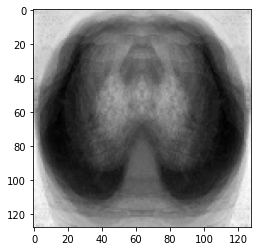

In [10]:
# sample from any coordinate region to visualize
y = np.array([[0, -110]])
prediction = autoencoder.decoder.predict(y)
plt.imshow(prediction.squeeze(), cmap='gray')

Install TensorflowJS for compatibility with HTML widget

In [ ]:
!pip install -q tensorflowjs

Save models

In [ ]:
import tensorflowjs as tfjs

path = !pwd
model_name = 'covidLatentSpace2' # string used to define filename of saved model
autoencoder.decoder.save(model_name + '-decoder.hdf5')
tfjs.converters.save_keras_model(autoencoder.decoder, str(path))

!pwd